# Pset8
YINING HUA

## 1. Solve by maximum likelihood

In [3]:
import numpy as np
import pandas as pd
import math
import scipy.stats as stats
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import re
import sys
% matplotlib inline

UsageError: Line magic function `%` not found.


### Read in the data

In [4]:
df = pd.read_table("w08-data.tbl.txt", header=[0,1], delim_whitespace=True)[1:]
sigma_true = [int(c[1].split("+-")[-1]) for c in df.columns]
sigma_true

[20, 2, 20, 5, 5, 20, 2, 20]

In [5]:
times = [4,4,8,8,16,16,24,24]  ## I've spent too much time on other research projects lemme save time for this

In [6]:
df = df.T.astype(float)
df

anise   kiwi  carrot  grape  tangerine  melon  clementine  spinach  \
4hr  +-20  23.76  74.46   62.08  55.74       0.00  48.00       72.22    39.62   
     +-2   23.19  54.53   72.83  43.46      18.83  27.93       56.16    27.26   
8hr  +-20  33.33  59.97   31.45  55.83      28.75  53.07       49.29     0.00   
     +-5   29.36  24.63   49.08  65.21      39.69  57.49       72.70    33.72   
16hr +-5   58.09  34.45   12.61  40.75      65.80  60.84       30.23    59.37   
     +-20  53.23   0.00   18.49  57.33      45.29  57.65       42.15    70.99   
24hr +-2   32.63  62.12   76.04  18.13      17.48  17.38       32.11    47.72   
     +-20  23.48  25.04   91.07  29.24      61.24   3.83        0.00    29.73   

            beet  huckleberry  lentil  cauliflower  
4hr  +-20  61.48        36.77   53.58        49.54  
     +-2   43.18        31.89   68.50        65.97  
8hr  +-20  15.43         0.00   83.86        77.94  
     +-5   28.25        20.23   78.84        54.80  
16hr +-5   37.14        51.81   15.83         9.68  
     +-20  43.53        87.98    9.53        30.73  
24hr +-2   61.96        53.55   43.90        54.75  
     +-20  40.37        66.11    0.00        20.60

### Max LLH

In [43]:
def cal_y_hat(b, a, phi, timepoint):
     return b + a*np.sin(2*math.pi*(timepoint+phi)/24)

def circadian_nll(p, real_exps, sigmas, timepoints):
    """ calculated the negative log likelihood of the circadian oscillatior distribution"""
    b, a, phi = p[0], p[1], p[2]    
    residuals = [real_exp - cal_y_hat(b,a,phi, timepoint) for real_exp, timepoint in zip(real_exps, timepoints)]
    ll = sum([stats.norm.logpdf(res, 0, s) for res,s in zip(residuals, sigmas)])
             
    return -ll

In [44]:
iteration = 20
def correct_phi(phi):
    """we want it between 0 and 24"""
    return phi%24

def correct_amplitude(amp, phi):
    """does +- for oscillation (cycles)"""
    if amp < 0: 
        return -amp, correct_phi(phi+12)
    return amp, correct_phi(phi)

def max_llh(gene):
    nll_best = float('inf')
    for i in range(iteration):
        x0 = [np.random.uniform(0, 100), np.random.uniform(0, 100), np.random.uniform(0, 24)]  ## initial guesses
        new_guess = optimize.minimize(circadian_nll, x0, (list(df[gene]), sigma_true, times), bounds = [(0.0,None), (None,None), (None, None)])
        if new_guess.fun < nll_best:
            a, phi = correct_amplitude(new_guess.x[1], new_guess.x[2])
            b = new_guess.x[0]
    return [b,a,phi]
            

In [45]:
max_llh_d = {gene:max_llh(gene) for gene in list(df.columns)}
max_llh_d

{'anise': [40.172719640062155, 17.24441075837993, 13.715490009581059],
 'kiwi': [41.51504464795965, 21.208736757201017, 5.73987417122181],
 'carrot': [44.65460463209814, 34.6760090290521, 4.158165384628033],
 'grape': [41.95482038258766, 27.71537342787658, 20.15963516076843],
 'tangerine': [40.927140766500806, 26.241820238795455, 15.993743200267215],
 'melon': [44.800173487202116, 27.890739642286846, 17.599525360643927],
 'clementine': [44.28898550968995, 25.27009545851369, 21.972214692908974],
 'spinach': [45.43016076299112, 20.33460090378709, 11.747027232266557],
 'beet': [41.57799037055371, 21.381024395821907, 7.543745791662715],
 'huckleberry': [42.48525255822614, 22.244336296755456, 9.946427259237577],
 'lentil': [44.49016063122901, 30.892175999158578, 23.730133312286416],
 'cauliflower': [39.70333981057692, 27.01266761216833, 2.0991253617804517]}

In [167]:
max_llh_df = pd.DataFrame.from_dict(max_llh_d, columns=["b(tpm) maxllh","a(tpm) maxllh","phi(hr) maxllh"], orient="index")
max_llh_df

,b(tpm) maxllh,a(tpm) maxllh,phi(hr) maxllh
anise,40.172720,17.244411,13.715490
kiwi,41.515045,21.208737,5.739874
carrot,44.654605,34.676009,4.158165
grape,41.954820,27.715373,20.159635
tangerine,40.927141,26.241820,15.993743
melon,44.800173,27.890740,17.599525
clementine,44.288986,25.270095,21.972215
spinach,45.430161,20.334601,11.747027
beet,41.577990,21.381024,7.543746
huckleberry,42.485253,22.244336,9.946427


### Moriarty's methods, OLS
Downloase from pset material, still, obviously not my code 

In [109]:
#! /usr/bin/env python3

# Moriarty's linear least squares answer for "the cycle of twelve"
#
# Usage:
#   ./moriarty.py w08-data.tbl
#

import numpy as np
import math
import re
import sys

# Ooh look! Parsing for the w08-data.tbl
# This leaves us with
#    N         : number of experiments (columns in the table)
#    G         : number of genes (rows in the table)
#    X[i]      : array of time points, in hrs, for the N experiments
#    S_true[i] : array of sigmas for the experiments
#    Y[i][t]   : GxN: observed tpm for gene i, time point t
#   
datafile = sys.argv[1]
with open("w08-data-mor.tbl.txt") as f:
    # First header line gives us the time points
    fields = f.readline().split()
    X = []
    for s in fields:
        match = re.search(r'^(\d+)hr', s)
        X.append(int(match.group(1)))
    N = len(X)

    # Second header line gives us "gene" followed by +=SD's
    fields = f.readline().split()

    # Third header line is just ------ stuff
    f.readline()

    # Remaining lines are data
    genenames = []
    Y = []
    for line in f.readlines():
        fields = line.split()
        genenames.append(fields[0])
        Y.append( np.array( [ float(s) for s in fields[1:]] ))
    G = len(Y)

X = times
S_true = sigma_true

# Moriarty's method: ordinary least squares on:
#    y_t = b + (a cos p) sin t + (a sin p) cos t
#
b_fit = np.zeros(G)
a_fit = np.zeros(G)
p_fit = np.zeros(G)

b_opt = np.zeros(G)
a_opt = np.zeros(G)
p_opt = np.zeros(G)

for g in range(G):
    # We have to set up a matrix A the way numpy.linalg.lstsq() wants it.
    #
    A = np.zeros((N, 3))  # observations x coefficients
    for i in range(N):
        A[i][0] = 1.
        A[i][1] = np.sin(2. * math.pi * X[i] / 24)  
        A[i][2] = np.cos(2. * math.pi * X[i] / 24)

    try:
        result    = np.linalg.lstsq(A, Y[g], rcond=-1)[0]
    except:
        sys.exit("Linear least square fit failed")

    p_fit[g]  = np.arctan(result[2] / result[1])   # in radians at first
    b_fit[g]  = result[0]
    a_fit[g]  = result[1] / np.cos(p_fit[g])

    p_fit[g] = 24 * p_fit[g] / (2 * math.pi)       # now in hours
    if a_fit[g] < 0:                               # there's a symmetry in the solution we have to deal with.
        a_fit[g]  = -a_fit[g]
        p_fit[g] += 12
    while p_fit[g] < 0:  p_fit[g] += 24
    while p_fit[g] > 24: p_fit[g] -= 24



## Output
#
print("{0:12s} {1:>6s} {2:>6s} {3:>6s}".format('genename', 'b', 'a', 'p'))
print("{0:12s} {1:6s} {2:6s} {3:6s}".format('-'*12, '-'*6,'-'*6,'-'*6))
for g in range(G):
    print("{0:12s} {1:6.2f} {2:6.2f} {3:6.2f}".format(genenames[g], b_fit[g], a_fit[g], p_fit[g]))



    
# Output the data set to a file
# Useful for checking if the parser works; compare to original table.
#
def output_data(outfile):
    with open(outfile, 'w') as f:
        print("{0:12s} ".format(""), end='', file=f)
        for i in range(N):
            print("{0:4.0f}hr ".format(X[i]), end='',file=f)
        print('', file=f)

        print("{0:12s} ".format("gene"), end='', file=f)
        for i in range(N):
            label = "+-{0:.0f}".format(S_true[i])
            print("{0:>6s} ".format(label), end='',file=f)
        print('',file=f)

        print("{0:12s} ".format("------------"), end='',file=f)
        for i in range(N):
            print("{0:6s} ".format("------"), end='',file=f)
        print('',file=f)

        for g in range(G):
            print("{0:12s} ".format(genenames[g]), end='',file=f)
            for i in range(N):
                print("{0:6.1f} ".format(Y[g][i]), end='',file=f)
            print('',file=f)
 

genename          b      a      p
------------ ------ ------ ------
anise         38.76  16.61  14.44
kiwi          36.53  21.48   2.13
carrot        44.81  37.24   4.81
grape         46.05  21.31  19.76
tangerine     39.52  19.77  13.42
melon         44.01  28.86  18.22
clementine    41.89  27.75  21.39
spinach       43.27  22.72  11.75
beet          40.63  17.22   7.30
huckleberry   48.45  34.77  10.29
lentil        38.06  42.31  22.39
cauliflower   40.60  25.65  23.32


## 2. Compare solutions
Moriarty is incensed that you have a different solution. He offers to bet you on who's right. Compute the total log likelihood (summed over all 12 genes) for Moriarty's solution and yours. Which is more likely, and by how much?

In [168]:
moriarty = pd.DataFrame.from_dict({'gene': genenames, 'b (tpm)': b_fit, 'a (tpm)': a_fit, 'phi (hr)':p_fit})
moriarty.sort_values(by="phi (hr)", ascending=False)

,gene,b (tpm),a (tpm),phi (hr)
11,cauliflower,40.604444,25.653985,23.318342
10,lentil,38.060000,42.310382,22.390031
6,clementine,41.894444,27.753693,21.386180
3,grape,46.050000,21.309820,19.756957
5,melon,44.008333,28.856294,18.224051
0,anise,38.758056,16.606215,14.437872
4,tangerine,39.521111,19.768456,13.424420
7,spinach,43.273333,22.718463,11.749583
9,huckleberry,48.446389,34.765362,10.289909
8,beet,40.630833,17.220725,7.298096


In [169]:
max_llh_df = max_llh_df.reset_index()
max_llh_df.insert(0,"gene", max_llh_df.pop("index"))
max_llh_df.sort_values(by="phi(hr) maxllh", ascending=False)

,gene,b(tpm) maxllh,a(tpm) maxllh,phi(hr) maxllh
10,lentil,44.490161,30.892176,23.730133
6,clementine,44.288986,25.270095,21.972215
3,grape,41.954820,27.715373,20.159635
5,melon,44.800173,27.890740,17.599525
4,tangerine,40.927141,26.241820,15.993743
0,anise,40.172720,17.244411,13.715490
7,spinach,45.430161,20.334601,11.747027
9,huckleberry,42.485253,22.244336,9.946427
8,beet,41.577990,21.381024,7.543746
1,kiwi,41.515045,21.208737,5.739874


In [170]:
max_llh_nll = sum([circadian_nll(max_llh_d[gene], list(df[gene]), sigma_true, times) for gene in df.columns])
max_llh_nll

317.8920121930598

In [171]:
mor_ols_nll = sum([circadian_nll([b_fit[i], a_fit[i], p_fit[i]], Y[i], sigma_true, times) for i in range(G)])
mor_ols_nll

556.3133834158384

In [172]:
# Ratio likelihood:
np.exp(mor_ols_nll - max_llh_nll)

3.5082124855809185e+103

So the probability of observing the data given by the maximum likelihood regression model is 3 times higher than the probability of observing the data given by the OLS model. I'd say our model must predict the data better. We'll see in part 3.

## 3. Plot the fits

Let's merge OLS and Max LLH results so we don't have different genes in the same plot

In [178]:
df = pd.merge(moriarty, max_llh_df, on="gene", how="outer")
df

,gene,b (tpm),a (tpm),phi (hr),b(tpm) maxllh,a(tpm) maxllh,phi(hr) maxllh
0,anise,38.758056,16.606215,14.437872,40.172720,17.244411,13.715490
1,kiwi,36.532222,21.483825,2.131418,41.515045,21.208737,5.739874
2,carrot,44.805278,37.237741,4.810584,44.654605,34.676009,4.158165
3,grape,46.050000,21.309820,19.756957,41.954820,27.715373,20.159635
4,tangerine,39.521111,19.768456,13.424420,40.927141,26.241820,15.993743
5,melon,44.008333,28.856294,18.224051,44.800173,27.890740,17.599525
6,clementine,41.894444,27.753693,21.386180,44.288986,25.270095,21.972215
7,spinach,43.273333,22.718463,11.749583,45.430161,20.334601,11.747027
8,beet,40.630833,17.220725,7.298096,41.577990,21.381024,7.543746
9,huckleberry,48.446389,34.765362,10.289909,42.485253,22.244336,9.946427


In [185]:
df = df.set_index("gene").T  ## for easily indexing genes
df

gene,anise,kiwi,carrot,grape,tangerine,melon,clementine,spinach,beet,huckleberry,lentil,cauliflower
b (tpm),38.758056,36.532222,44.805278,46.050000,39.521111,44.008333,41.894444,43.273333,40.630833,48.446389,38.060000,40.604444
a (tpm),16.606215,21.483825,37.237741,21.309820,19.768456,28.856294,27.753693,22.718463,17.220725,34.765362,42.310382,25.653985
phi (hr),14.437872,2.131418,4.810584,19.756957,13.424420,18.224051,21.386180,11.749583,7.298096,10.289909,22.390031,23.318342
b(tpm) maxllh,40.172720,41.515045,44.654605,41.954820,40.927141,44.800173,44.288986,45.430161,41.577990,42.485253,44.490161,39.703340
a(tpm) maxllh,17.244411,21.208737,34.676009,27.715373,26.241820,27.890740,25.270095,20.334601,21.381024,22.244336,30.892176,27.012668
phi(hr) maxllh,13.715490,5.739874,4.158165,20.159635,15.993743,17.599525,21.972215,11.747027,7.543746,9.946427,23.730133,2.099125


In [182]:
time_ticks = np.arange(0, 24.1, 0.1)
mor_predictions = np.array([np.array([cal_y_hat(df[gene][0], df[gene][1], df[gene][2], t) 
                                          for t in time_ticks]) for gene in df.columns])
mor_predictions.shape

(12, 241)

In [183]:
max_llh_predictions = np.array([np.array([cal_y_hat(df[gene][3], df[gene][4], df[gene][5], t) 
                                          for t in time_ticks]) for gene in df.columns])
max_llh_predictions.shape

(12, 241)

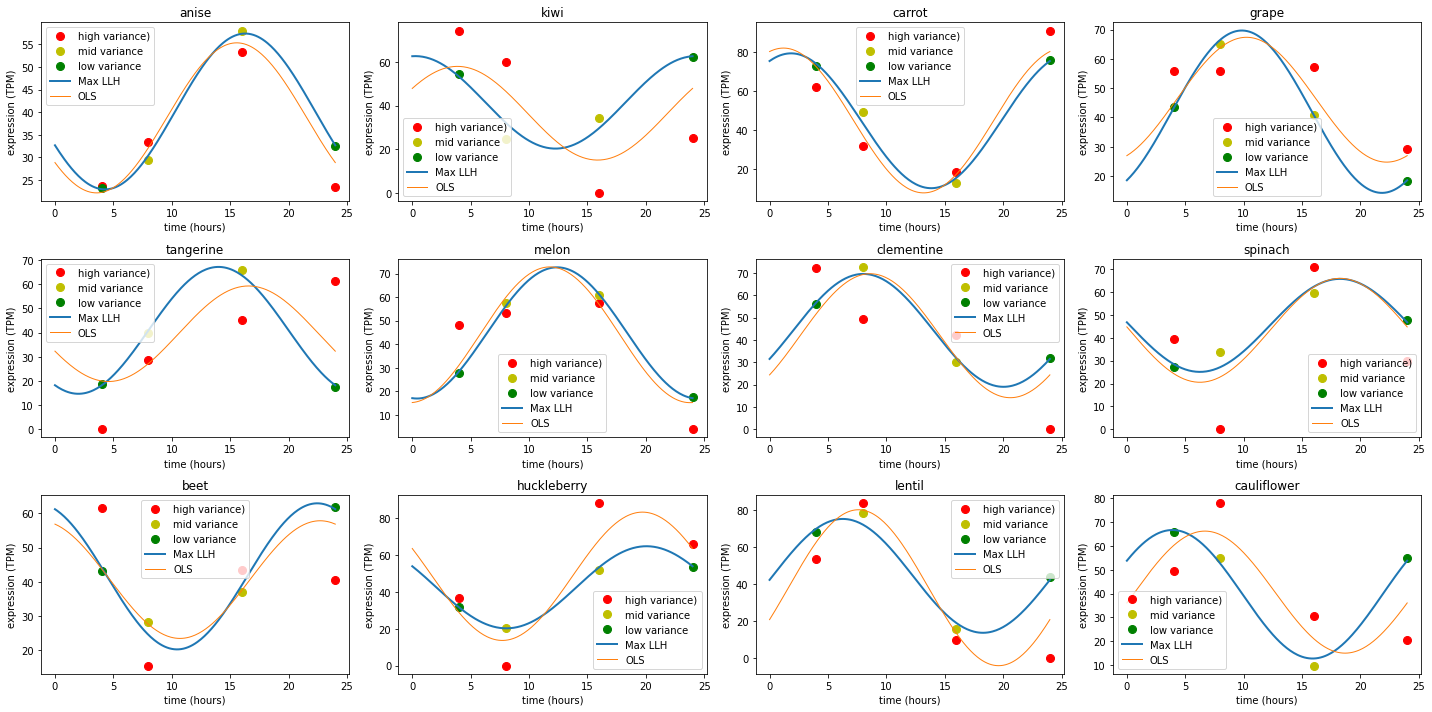

In [193]:
f = plt.figure(figsize=(20,10))
for i in range(G):
    ax = f.add_subplot(3,4,i+1)
    ax.plot(times[np.where(sigma_true == 20)], Y[i][np.where(sigma_true == 20)], 'ro', markersize=8)  
    ax.plot(times[np.where(sigma_true == 5)], Y[i][np.where(sigma_true == 5)], 'yo', markersize=8)  
    ax.plot(times[np.where(sigma_true == 2)], Y[i][np.where(sigma_true == 2)], 'go', markersize=8)   
    plt.xlabel('time (hours)')
    plt.ylabel('expression (TPM)')
    plt.title(genenames[i])
    ax.plot(time_ints, max_llh_predictions[i], '-', linewidth=2)
    ax.plot(time_ints, mor_predictions[i], '-',  linewidth=1)
    ax.legend(['high variance)', 'mid variance', 'low variance',
               'Max LLH','OLS'])
    ax.plot()
plt.tight_layout()

The plots are quite hard to parse since they contain quite a lot of information. But we can sort of see a tendency that the predictions made by the max likelihood model are closer to the low and mid variance dots (geren and yellow dots falling near the blue line), while also not being affected that much by high variances (red dots), as compared to Moriarty's OLS model. The OLS seems to be dragged towards high variance points. So Moriarty chose a model that didn't explain the data well, that's where he went wrong.